In [1]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [2]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [51]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(4))
basekat.parseCommands("""
qnoised NSR_shot_rad 1 $fs nOMC_AROC_trans
qd qdA 0 0 nOMC_AROC_trans
qd qdP 0 90 nOMC_AROC_trans
sd sd00 0 0 0 nOMC_AROC_trans
sd sd01 0 0 1 nOMC_AROC_trans
sd sd02 0 0 2 nOMC_AROC_trans
sd sd03 0 0 3 nOMC_AROC_trans
sd sd04 0 0 4 nOMC_AROC_trans

sd sd00OFI 0 0 0 nlensFC1a
sd sd01OFI 0 0 1 nlensFC1a
sd sd02OFI 0 0 2 nlensFC1a
sd sd03OFI 0 0 3 nlensFC1a
sd sd04OFI 0 0 4 nlensFC1a
""")
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SR3_Rc_orig = kat.SR3.Rc.value
SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd03 0 0 3 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd04 0 0 4 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nlensFC1a` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nlensFC1a` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02OFI 0 0 2 nlensFC1a` into pykat object not implemented yet, added as extra line.
Parsing `sd sd

In [5]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [6]:
darm_list = []
freq = []

f_overlap_SRC_to_ARM_x=[]
f_overlap_SRC_to_ARM_y=[]

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

In [48]:
###
###Extract the eigenmode of SRC with offsets in SR3
###

max_offset_SR3 = .01634 #20cm Roc change in SR3 curvature
#max_offset_SR3 = 0

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]
get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

#Add Commands
basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(commands)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(pds)
basekat1.parseCommands(add_squeezing)
basekat1.undumpNodes()
basekat1.parseCommands("maxtem "+str(2))
basekat1.parseCommands("qnoised NSR_shot 1 $fs nOMC_AROC_trans")
kat1=basekat1.deepcopy() 
kat1.verbose = False

# Change the SRMHR_Roc
SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat1.SR3.Rcx.value = SR3_Rc_new
kat1.SR3.Rcy.value = SR3_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SR3_roc = kat1.run()
   
#### Extract the mode at the SRMAR w.r.t the ARM
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavXARM.enabled = True
kat1.cavYARM.enabled = True

get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)
    
    
#### Extract the mode at the OFI w.r.t the OMC
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavOMC.enabled = True
get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)

get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))

q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [49]:
basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(darm_commands)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(pds)
basekat1.parseCommands(add_squeezing)
basekat1.parseCommands("maxtem "+str(4))
basekat1.parseCommands("""
qnoised NSR_shot_rad 1 $fs nOMC_AROC_trans

qd qdA 0 0 nOMC_AROC_trans
qd qdP 0 90 nOMC_AROC_trans

sd sd00 0 0 0 nOMC_AROC_trans
sd sd01 0 0 1 nOMC_AROC_trans
sd sd02 0 0 2 nOMC_AROC_trans
sd sd03 0 0 3 nOMC_AROC_trans
sd sd04 0 0 4 nOMC_AROC_trans

sd sd00OFI 0 0 0 nIMFC1
sd sd01OFI 0 0 1 nIMFC1
sd sd02OFI 0 0 2 nIMFC1
sd sd03OFI 0 0 3 nIMFC1
sd sd04OFI 0 0 4 nIMFC1

pd1 signal $fs nOMC_AROC_trans
""")
basekat1.undumpNodes()

kat1=basekat1.deepcopy()
kat1.verbose = False
    
SR3_Rc = kat.SR3.Rc
dRc = max_offset_SR3
    
kat1.SR3.Rcx.value = SR3_Rc + dRc
kat1.SR3.Rcy.value = SR3_Rc + dRc


#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0]
q2 = q_refout_x_list[0]
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat1.lSRMTT1.L.value = d1
kat1.SRMTT1.f.value = f1
kat1.lSRMTT2.L.value = d2
kat1.SRMTT2.f.value = f2
kat1.lIBAin.L.value = d3

out1 = kat1.run()

freq.append(out1.x)
darm_list.append(out1['NSR_with_RP'])
kat1.saveScript("VarySR3_95MM_wSqz_MMTTon_maxtem4.kat")


#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd03 0 0 3 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd04 0 0 4 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02OFI 0 0 2 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd03OFI 0 0

In [46]:
kat.SRMHR.T.value

0.2

In [10]:
f_overlap_SRC_to_ARM_x

[0.9500514484454374]

In [11]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

SRMRoc_offset = []
max_offset = .4661 #50cm Roc change in SRM curvature

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

#Add Commands
basekat2 = pykat.finesse.kat() 
basekat2.loadKatFile(katfile)
basekat2.parseCommands(commands)
basekat2.parseCommands(amplitude_detectors)
basekat2.parseCommands(pds)
basekat2.parseCommands("maxtem "+str(4))
basekat2.parseCommands(add_squeezing)
basekat2.undumpNodes()
kat2=basekat2.deepcopy() 
kat2.verbose = False

# Change the SRMHR_Roc
SRMHR_Rc_new = SRMHR_Rc_orig + max_offset
kat2.SRMHR.Rcx.value = SRMHR_Rc_new
kat2.SRMHR.Rcy.value = SRMHR_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SRM_roc = kat2.run()

#### Extract the mode at the SRMAR w.r.t the ARM
for cav in kat2.getAll(pykat.commands.cavity):
    cav.enabled = False
kat2.cavXARM.enabled = True
kat2.cavYARM.enabled = True

get_SRM_q_wrt_cavARM = kat2.run(getTraceData=True)
get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)


#### Extract the mode at the OFI w.r.t the OMC
for cav in kat2.getAll(pykat.commands.cavity):
    cav.enabled = False
kat2.cavOMC.enabled = True
get_OFI_qx_wrt_OMC = kat2.run(getTraceData=True)
get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [12]:
get_OFI_qx_wrt_OMC_list

[(-3.0384235724512698+1.11364877778933j)]

In [13]:
f_overlap_SRC_to_ARM_x

[0.9500514484454374]

In [14]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI

basekat2 = pykat.finesse.kat() 
basekat2.loadKatFile(katfile)
basekat2.parseCommands(darm_commands)
basekat2.parseCommands(amplitude_detectors)
basekat2.parseCommands("maxtem "+str(4))
basekat2.parseCommands(pds)
basekat2.parseCommands(add_squeezing)
basekat2.undumpNodes()
kat2=basekat2.deepcopy()
kat2.verbose = False


SRMHR_Rc = kat.SRMHR.Rc
dRc = max_offset
print(dRc)
kat2.SRMHR.Rcx.value = SRMHR_Rc + dRc
kat2.SRMHR.Rcy.value = SRMHR_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x_list[0]
q2 = q_refout_x_list[0]
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat2.lSRMTT1.L.value = d1
kat2.SRMTT1.f.value = f1
kat2.lSRMTT2.L.value = d2
kat2.SRMTT2.f.value = f2
kat2.lIBAin.L.value = d3

out2 = kat2.run()

freq.append(out2.x)
darm_list.append(out2['NSR_with_RP'])
kat2.saveScript("VarySRM_95MM_wSqz_MMTTon_maxtem4.kat")

#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat2,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat2,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat2,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))


0.4661
Successfully Mode-Matched! >99.9% overlap
f1 is -0.049162843193602715
f2 is 0.04928017977955772


In [37]:
kat.SRMHR.T.value

0.35

In [16]:
MMTL_f_offset = []

#Add Commands
basekat3 = pykat.finesse.kat() 
basekat3.loadKatFile(katfile)
basekat3.parseCommands(darm_commands)
basekat3.parseCommands(amplitude_detectors)
basekat3.parseCommands(pds)
basekat3.parseCommands(add_squeezing)
basekat3.parseCommands("maxtem "+str(4))
basekat3.undumpNodes()
kat3=basekat3.deepcopy() 
kat3.verbose = False

# Change the SRMTT f 
kat3.SRMTT1.f.value = 26.85

#Run and extract the q's at the OFI and SRMHR
out_new3 = kat3.run()
freq.append(out_new3.x)

darm_list.append(out_new3['NSR_with_RP'])
kat3.saveScript("VaryMMTT_95MM_wSqz_MMTTon_maxtem4.kat")
#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat3,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat3,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat3,'cavOMC')

f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

f_overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
f_overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))



In [17]:
kat1.SRMTT1.f.value

0.001495753375465786

In [18]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat_nosqz = pykat.finesse.kat() 
basekat_nosqz.loadKatFile(katfile)
basekat_nosqz.parseCommands(darm_commands)
basekat_nosqz.parseCommands(amplitude_detectors)
basekat_nosqz.parseCommands(pds)
basekat_nosqz.parseCommands("maxtem "+str(4))
basekat_nosqz.undumpNodes() #undump the vacuum nodes
kat_nosqz=basekat_nosqz.deepcopy() #copy kat code
kat_nosqz.verbose = False

out_perfect_mm_nosqz = kat_nosqz.run()


In [19]:
f_overlap_OMC_to_ARM_x

[0.9500668938955157]

In [20]:
varyMMT_data_maxtem6 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varyMMT_data_maxtem6_freq,varyMMT_data_maxtex6_darm= load(varyMMT_data_maxtem6)

varyMMT_data_maxtem8 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varyMMT_data_maxtem8_freq,varyMMT_data_maxtex8_darm= load(varyMMT_data_maxtem8)

varyMMT_data_maxtem10 = np.loadtxt('./HigherOrderSims/VaryMMTT_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varyMMT_data_maxtem10_freq,varyMMT_data_maxtex10_darm= load(varyMMT_data_maxtem10)

In [21]:
varySRM_data_maxtem6 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varySRM_data_maxtem6_freq,varySRM_data_maxtex6_darm= load(varySRM_data_maxtem6)

varySRM_data_maxtem8 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varySRM_data_maxtem8_freq,varySRM_data_maxtex8_darm= load(varySRM_data_maxtem8)

varySRM_data_maxtem10 = np.loadtxt('./HigherOrderSims/VarySRM_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varySRM_data_maxtem10_freq,varySRM_data_maxtex10_darm= load(varySRM_data_maxtem10)

In [22]:
varySR3_data_maxtem6 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem6.out',comments='%')
varySR3_data_maxtem6_freq,varySR3_data_maxtex6_darm= load(varySR3_data_maxtem6)

varySR3_data_maxtem8 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem8.out',comments='%')
varySR3_data_maxtem8_freq,varySR3_data_maxtex8_darm= load(varySR3_data_maxtem8)

varySR3_data_maxtem10 = np.loadtxt('./HigherOrderSims/VarySR3_95MM_wSqz_MMTTon_maxtem10.out',comments='%')
varySR3_data_maxtem10_freq,varySR3_data_maxtex10_darm= load(varySR3_data_maxtem10)

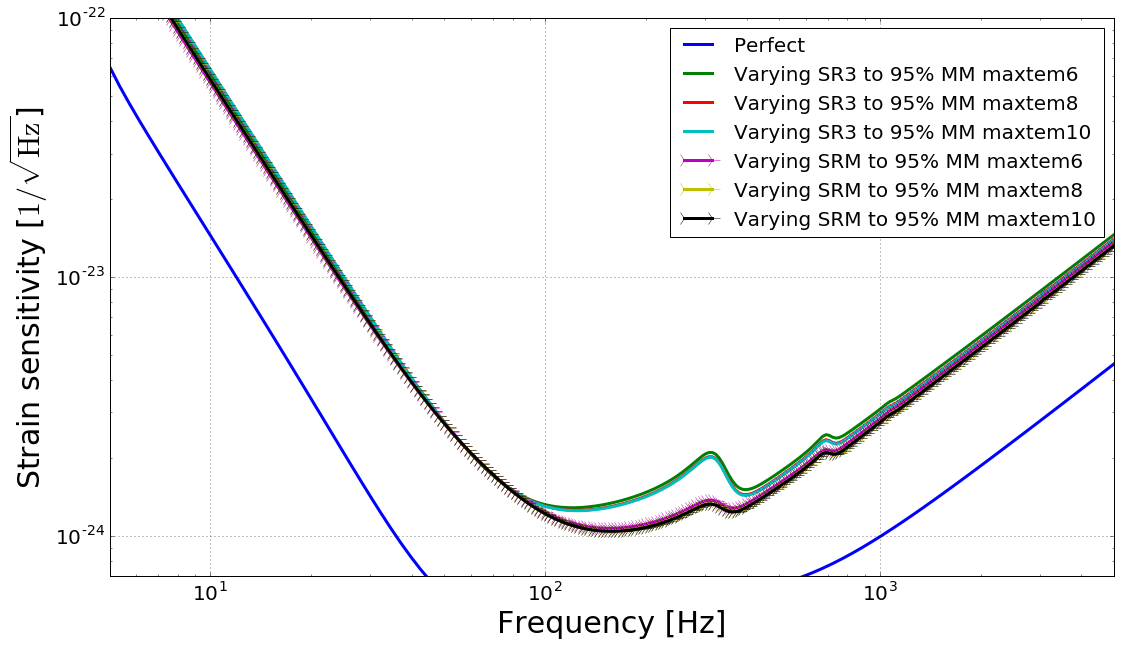

In [23]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)
pl.loglog(freq[0], np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='Perfect')
#pl.loglog(freq[0], np.real(darm_dict['Varying SR3 to 95% MM']),linewidth=3,label='Varying SR3 to 95% MM maxtem4')
pl.loglog(varySR3_data_maxtem6_freq, varySR3_data_maxtex6_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem6')
pl.loglog(varySR3_data_maxtem8_freq, varySR3_data_maxtex8_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem8')
pl.loglog(varySR3_data_maxtem10_freq, varySR3_data_maxtex10_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem10')


#pl.loglog(freq[0], np.real(darm_dict['Varying SRM to 95% MM']),'o-',linewidth=1,label='Varying SRM to 95% MM maxtem4')
pl.loglog(varySRM_data_maxtem6_freq, varySRM_data_maxtex6_darm,'4-',linewidth=3,\
          markersize=15,label='Varying SRM to 95% MM maxtem6')
pl.loglog(varySRM_data_maxtem8_freq, varySRM_data_maxtex8_darm,'4-',linewidth=3,\
          markersize=15,label='Varying SRM to 95% MM maxtem8')
pl.loglog(varySRM_data_maxtem10_freq, varySRM_data_maxtex10_darm,'4-',linewidth=3,\
          markersize=15,label='Varying SRM to 95% MM maxtem10')


#pl.loglog(freq[0], np.real(darm_dict['Varying MMT to 95% MM(between OMC and Arms)']),linewidth=3\
#          ,label='Varying MMT to 95% MM(between OMC and Arms)')


#pl.title("QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(7e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompareSR3SRMmaxTEM_wSqz.png")

pl.show()



/home/thomasvo/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


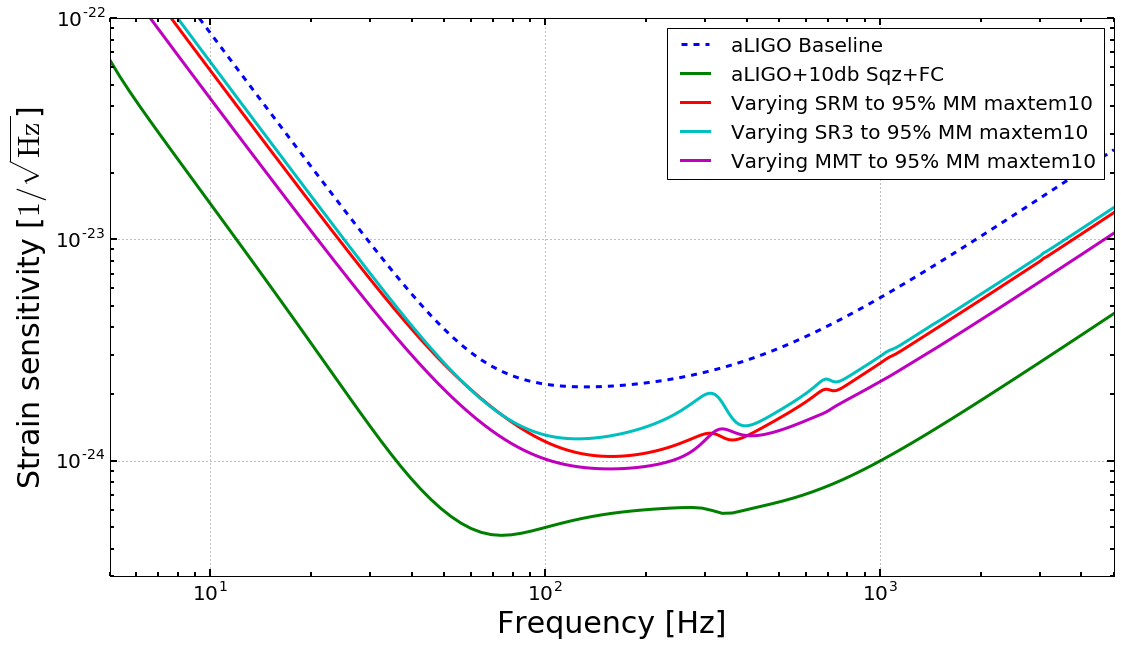

In [24]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)

pl.loglog(freq[0], out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')
pl.loglog(freq[0], np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='aLIGO+10db Sqz+FC')

pl.loglog(varySRM_data_maxtem10_freq, varySRM_data_maxtex10_darm,linewidth=3,label='Varying SRM to 95% MM maxtem10')
pl.loglog(varySR3_data_maxtem10_freq, varySR3_data_maxtex10_darm,linewidth=3,label='Varying SR3 to 95% MM maxtem10')
pl.loglog(varyMMT_data_maxtem10_freq, varyMMT_data_maxtex10_darm,linewidth=3,label='Varying MMT to 95% MM maxtem10')


pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)

pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)


pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompareAll_wSqz.png")

pl.show()


/home/thomasvo/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


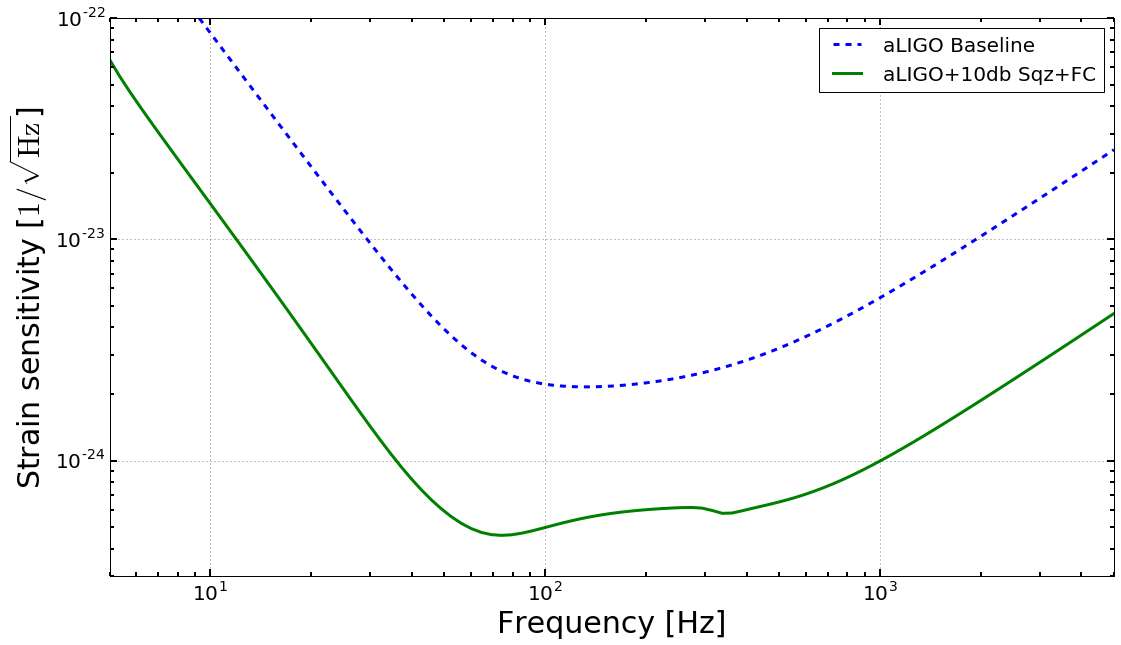

In [25]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)

pl.loglog(freq[0], out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')
pl.loglog(freq[0], np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='aLIGO+10db Sqz+FC')

pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompare_SqzNoSqz.png")

pl.show()

/home/thomasvo/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


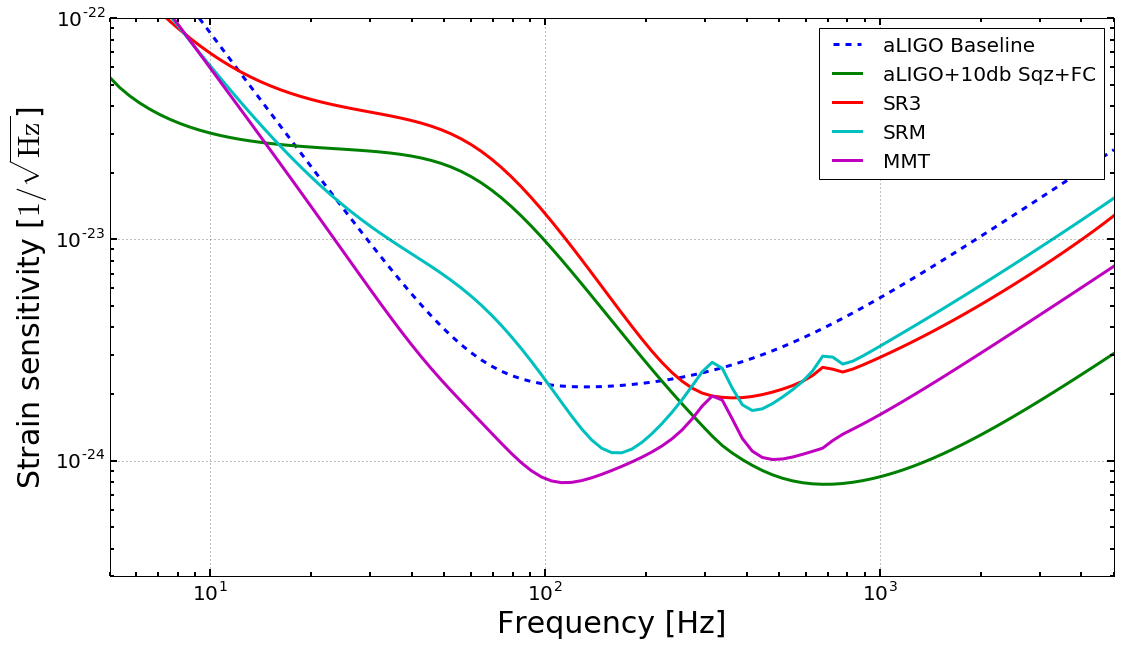

In [50]:
pl.figure(figsize=(18, 10), dpi=80)
pl.subplot(111)

pl.loglog(freq[0], out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3, label='aLIGO Baseline')
pl.loglog(freq[0], np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='aLIGO+10db Sqz+FC')

pl.loglog(freq[0], np.real(out1['NSR_with_RP']),linewidth=3, label='SR3')
pl.loglog(freq[0], np.real(out2['NSR_with_RP']),linewidth=3, label='SRM')
pl.loglog(freq[0], np.real(out_new3['NSR_with_RP']),linewidth=3, label='MMT')

pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

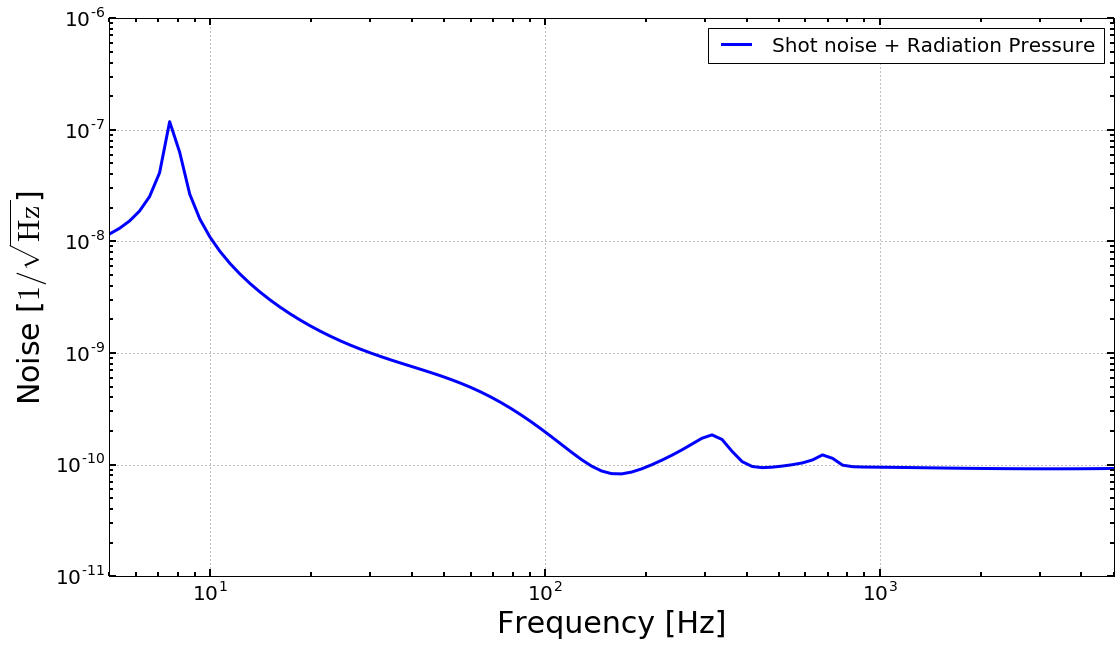

In [27]:
pl.figure(figsize=(18, 10), dpi=80)

#qshot NSR_shot 1 $fs nOMC_AROC_trans
#qnoised NSR_shot_rad 1 $fs nOMC_AROC_trans
#qd qdA 0 0 nOMC_AROC_trans
#qd qdP 0 90 nOMC_AROC_trans


pl.subplot(111)
pl.loglog(freq[0], np.real(out1['NSR_shot_rad']),linewidth=3, label='Shot noise + Radiation Pressure')

#pl.xlim(200,900)
#pl.ylim(7e-11,3e-10)
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Noise [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

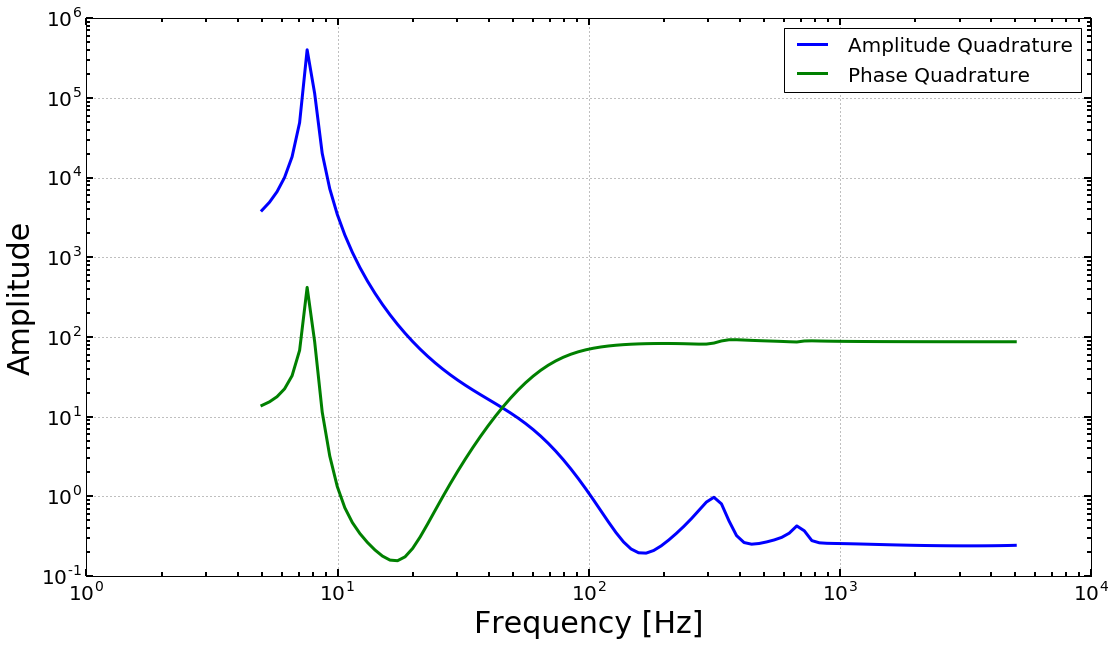

In [28]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)
pl.loglog(freq[0], np.real(out1['qdA']),linewidth=3, label='Amplitude Quadrature')
pl.loglog(freq[0], np.real(out1['qdP']),linewidth=3, label='Phase Quadrature')



#pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Amplitude",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

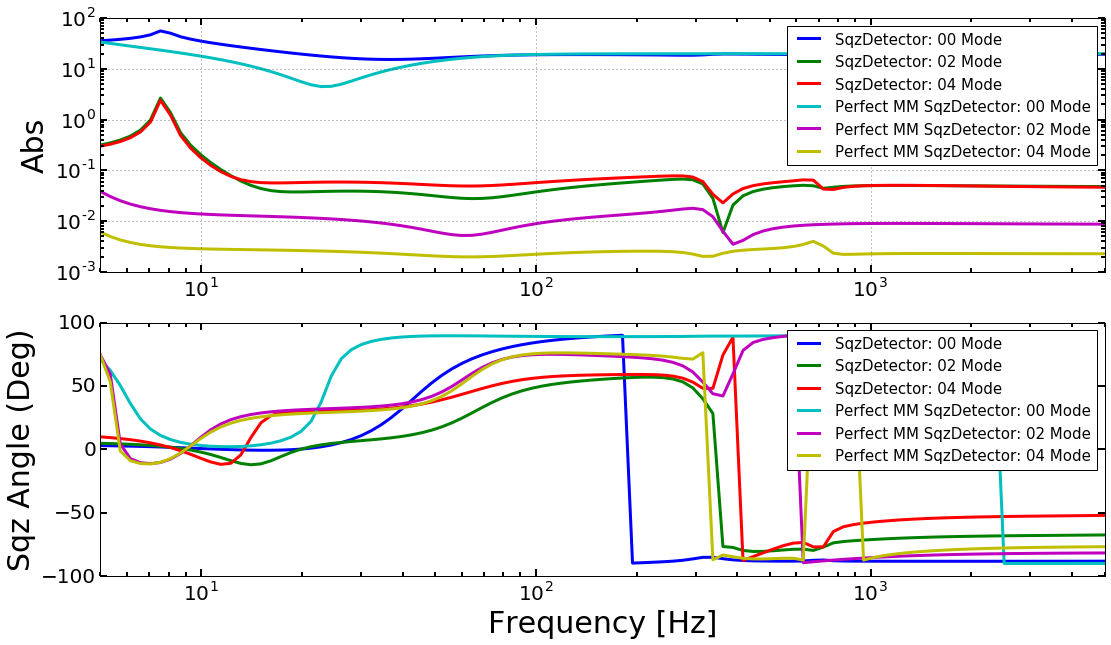

In [36]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(211)
pl.loglog(freq[0], np.absolute(out1['sd00']),linewidth=3, label='SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out1['sd02']),linewidth=3, label='SqzDetector: 02 Mode')
pl.loglog(freq[0], np.absolute(out1['sd04']),linewidth=3, label='SqzDetector: 04 Mode')
pl.loglog(freq[0], np.absolute(out_perfect_mm['sd00']),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out_perfect_mm['sd02']),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')
pl.loglog(freq[0], np.absolute(out_perfect_mm['sd04']),linewidth=3, label='Perfect MM SqzDetector: 04 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.subplot(212)
pl.semilogx(freq[0], np.angle(out1['sd00'],deg=True),linewidth=3, label='SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out1['sd02'],deg=True),linewidth=3, label='SqzDetector: 02 Mode')
pl.semilogx(freq[0], np.angle(out1['sd04'],deg=True),linewidth=3, label='SqzDetector: 04 Mode')
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd00'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd02'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd04'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 04 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Sqz Angle (Deg)",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.legend(fontsize=15)

pl.show()

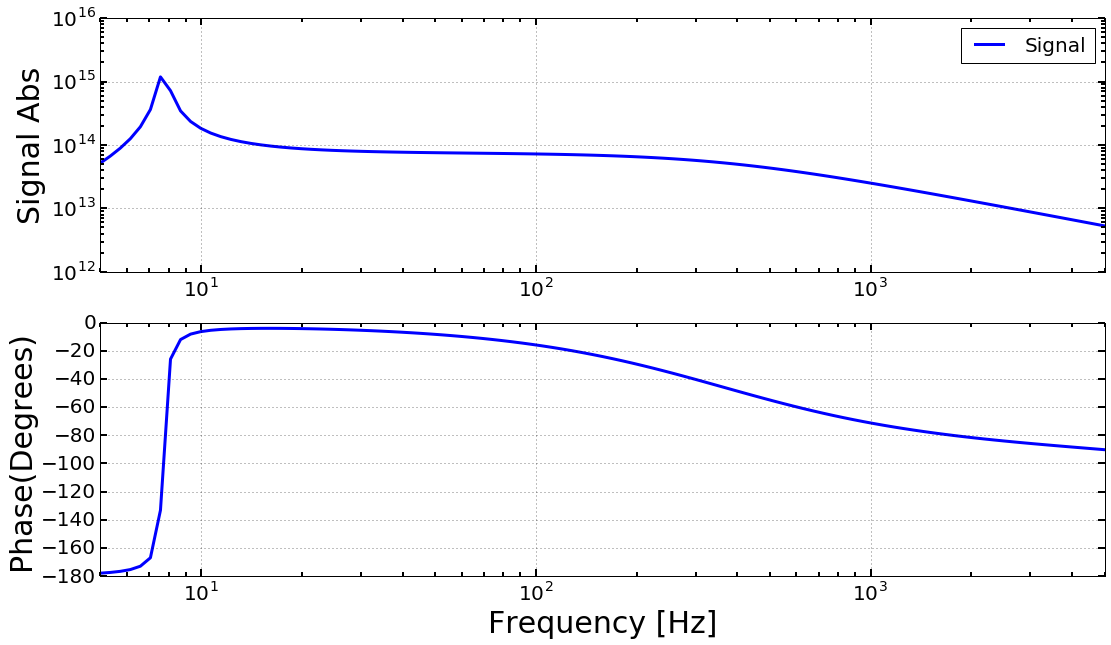

In [30]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(211)
pl.loglog(freq[0], np.absolute(out1['signal']),linewidth=3, label='Signal')
###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.ylabel("Signal Abs",fontsize=30)
pl.legend(fontsize=20)


pl.subplot(212)
pl.semilogx(freq[0], np.angle(out1['signal'],deg=True),linewidth=3, label='Signal')

pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Phase(Degrees)",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

pl.show()

In [31]:
pl.figure(figsize=(18, 10), dpi=80)



In [32]:
out1['sd02OFI']

array([ nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj,
        nan+nanj,  nan+nanj,  nan+nanj,  nan+nanj, 